# Data Collection
First, collecting data from https://en.wikipedia.org/wiki/List_of_active_nationalist_parties_in_Europe and parse the table.

In [1]:
import json
import requests
import wikipedia
import wikitables

def wiki_table_sanitizer (entry):
    sanitized = {}
    for key, val in entry.items():
        if type(val) == wikitables.models.Field:
            sanitized[key] = str(val)
        else:
            sanitized[key] = val
    return sanitized
            
def get_wiki_page (title, country):
    wiki_endpoint = 'https://en.wikipedia.org/w/api.php'
    payload = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'revisions',
        'rvprop': 'content',
        'utf8': 'true'
    }
    request = requests.get(wiki_endpoint, params = payload)
    print 'GET ', request.url
    data = json.loads(request.text)
    if country == 'STOP':
        return data
    try: 
        pages = data['query']['pages']
        page_id = pages.keys()[0]
        revisions = pages[page_id]['revisions'][0]['*']
        if ('#REDIRECT' in revisions):
            pattern = r'\[\[(.*?)\]\]'
            original_title =  re.findall(pattern, revisions)[0]
            print 'Redirecting to', original_title
            return get_wiki_page(original_title, country)
        try:
            wikipedia.page(title)
        except:
            augmented_title = '{} ({})'.format(title, country, title)
            return get_wiki_page(augmented_title, country)
        return data
    except KeyError:
        return data


In [62]:
# wikitables from https://github.com/bcicen/wikitables is used to 
# quickly and easily get the contents of the tables on the page

list_name = 'List of active nationalist parties in Europe'

from wikitables import import_tables
tables = import_tables(list_name)
parties = tables[0].rows
print 'Keys for every party'
for key in parties[0].keys():
    print ' - ', key
print tables[0].name 
for row in parties:
    print ' - ', row['Country'], ':', row['Party']

Keys for every party
 -  Votes
 -  % of popular vote
 -  Europarty
 -  Country
 -  Ideology, description
 -  Seats
 -  Party
 -  Date established
List of active nationalist parties in Europe[0]
 -  Hungary : Fidesz
 -  Armenia : Republican Party of Armenia
 -  Macedonia : VMRO-DPMNE
 -  Poland : Law and Justice
 -  Switzerland : Swiss People's Party
 -  Austria : Freedom Party of Austria
 -  Denmark : Danish People's Party
 -  Belgium : New Flemish Alliance
 -  Hungary : Jobbik
 -  Finland : Finns Party
 -  Italy : Lega Nord
 -  Latvia : National Alliance
 -  Norway : Progress Party
 -  Ireland : Sinn Féin
 -  France : National Front
 -  Netherlands : Party for Freedom
 -  Sweden : Sweden Democrats
 -  Germany : Alternative for Germany
 -  Russia : LDPR
 -  Norway : Centre Party
 -  Bulgaria : IMRO – Bulgarian National Movement
 -  Bulgaria : National Front for the Salvation of Bulgaria
 -  Bulgaria : Attack
 -  Slovakia : Slovak National Party
 -  Estonia : Conservative People's Party

Now that we have the contents of the table containing all the listed parties and some basic stats about them (country, number of votes etc.), we can go into the page for every party and fetch the contents. From this we'll try to parse out any non-trivial links (navigation and headers and so on) and try to build a network out of these.

In [63]:
import re

blacklist = [
    'Category',
    'list',
    'file:',
    'wiktionary:',
    'national conservatism', 
    'european parliament election',
    'right-wing populism', 
    'far-right politics', 
    'european parliament',
    'social conservatism',
    'Right-wing populism', 
    'Far-right politics', 
#     'Euroscepticism', 
    'European Union', 
    'far-right',
    'right-wing',
    'Right-wing politics', 
    'political party',
    'baron',
]

def processLink(link):
    decoded = link.encode('utf-8')
    split = re.split(r'[(|]+', decoded)
    return split[0]

def checkLink(link):
    return any(substring.lower() in link.lower() for substring in blacklist)

def clean_links (links):
    processed = [processLink(link) for link in links]
    return [link for link in processed if not checkLink(link)]

def getWikiLinks(text):
    pattern = r'\[\[(.*?)\]\]'
    links = re.findall(pattern, text)
    return clean_links(links)

def clean_name(name):
    for ch in [' ', '-']:
        name = name.replace(ch, '_')
    for ch in [",", ".",'–']:
        name = name.replace(ch, '')
    return name.lower().decode('utf-8').encode('ascii', 'replace')

for i, party in enumerate(parties):
    party = dict(party)
    party_name = str(party['Party'])
    if '–' in party_name:
        party_name = party_name.split('–')[0]
    country = str(party['Country'])
    party_title = clean_name(party_name)
    party['title'] = party_title
    print 'Party name:', party_name, country
    try:
        page = wikipedia.page(party_name)
        party['links'] = clean_links(page.links)
        print 'Found', len(party['links']), 'links\n'
        if len(party['links']) < 20:
            print json.dumps(pages_json, indent=2)
    except Exception as e:
        print e
        try:
            pages_json = get_wiki_page(party_name, country)
            pages = pages_json['query']['pages']
            for key in pages.keys():
                text = pages[key]['revisions'][0]['*']
                party['links'] = list(set(getWikiLinks(text)))
                print 'Found', len(party['links']), 'links\n'
        except:
            try:
                pages_json = get_wiki_page(party_name, 'political party')
                pages = pages_json['query']['pages']
                for key in pages.keys():
                    text = pages[key]['revisions'][0]['*']
                    party['links'] = list(set(getWikiLinks(text)))
                    print 'Found', len(party['links']), 'links\n'
            except:
                print '--------- Failed to fetch text for', party_name, '\n'
                party['links'] = []
    parties[i] = party    


Party name: Fidesz Hungary
Found 326 links

Party name: Republican Party of Armenia Armenia
Found 149 links

Party name: VMRO-DPMNE Macedonia
Found 328 links

Party name: Law and Justice Poland
Found 280 links

Party name: Swiss People's Party Switzerland
Found 155 links

Party name: Freedom Party of Austria Austria
Found 286 links

Party name: Danish People's Party Denmark
Found 128 links

Party name: New Flemish Alliance Belgium
Found 236 links

Party name: Jobbik Hungary
Found 235 links

Party name: Finns Party Finland
Found 230 links

Party name: Lega Nord Italy
Found 686 links

Party name: National Alliance Latvia
"National Alliance" may refer to: 
National Alliance (Egypt)
Nation Alliance (Turkey)
Anguilla National Alliance
National Alliance (Australia)
National Alliance (Greece)
National Alliance (Italy)
National Alliance (Latvia)
National Alliance (Netherlands)
National Alliance (Norway)
National Alliance (Pakistan)
National Alliance (Peru)
National Alliance (Portugal)
National

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=New+Force&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=New+Force+%28Italy%29&action=query
Found 64 links

Party name: Estonian Independence Party Estonia
Found 72 links

Party name: Bulgarian National Union  Bulgaria
Found 120 links

Party name: Tricolour Flame Italy
Found 158 links

Party name: Congress of Ukrainian Nationalists Ukraine
Found 246 links

Party name: Spanish Falange of the JONS Spain
Found 436 links

Party name: España 2000 Spain
Found 113 links

Party name: Congress of the New Right Poland
Found 122 links

Party name: Self-Defence of the Republic of Poland Poland
Found 138 links

Party name: National Democracy Spain
Found 280 links

Party name: British National Party United Kingdom
Found 695 links

Party name: Britain First United Kingdom
Found 456 links

Party name: La Falange Spain
Found 103 links

Party

With all data collected as a list of parties with the links from their pages stored within, two graphs are constructed. One that where edges are created when a party's page's links contain another party directly (first order), and one where the edges consist of two party's that have a common link (second order). The latter will have the link stored on the edge attribute.

In [158]:
import networkx as nx

# initialize multiple directed graphs
graph_first = nx.Graph()
graph_scnd = nx.Graph()


for party in parties:
    # add nodes to both graphs
    graph_first.add_node(party['title'], **dict(wiki_table_sanitizer(party)))
    graph_scnd.add_node(party['title'], **dict(wiki_table_sanitizer(party)))

    
for i, party in enumerate(parties):
    links = party['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if graph_first.has_node(clean_link):
            graph_first.add_edge(clean_link, party['title'])
        for j, party2 in enumerate(parties):
            # add an edge if two party's pages have a link in commonn to 'second'
            if i != j:
                links2 = party2['links']
                for link2 in links2:
                    if link == link2 and not graph_scnd.has_edge(party2['title'], party['title']):
                        graph_scnd.add_edge(party2['title'], party['title'], link=clean_link)

Some very basic visualization of these graphs.

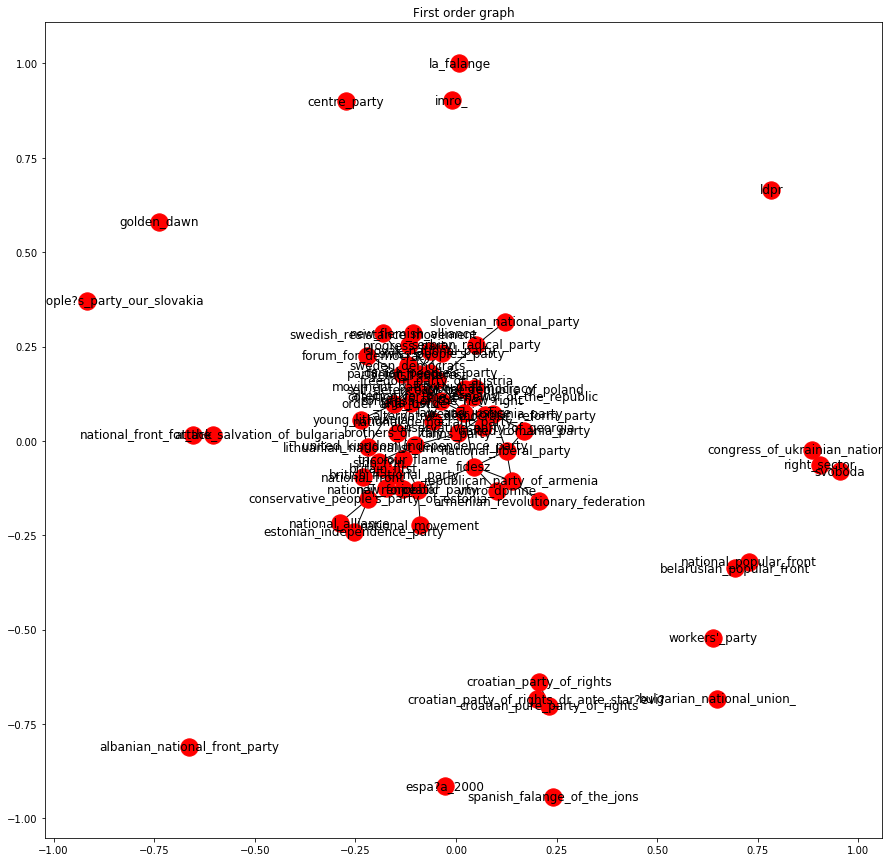

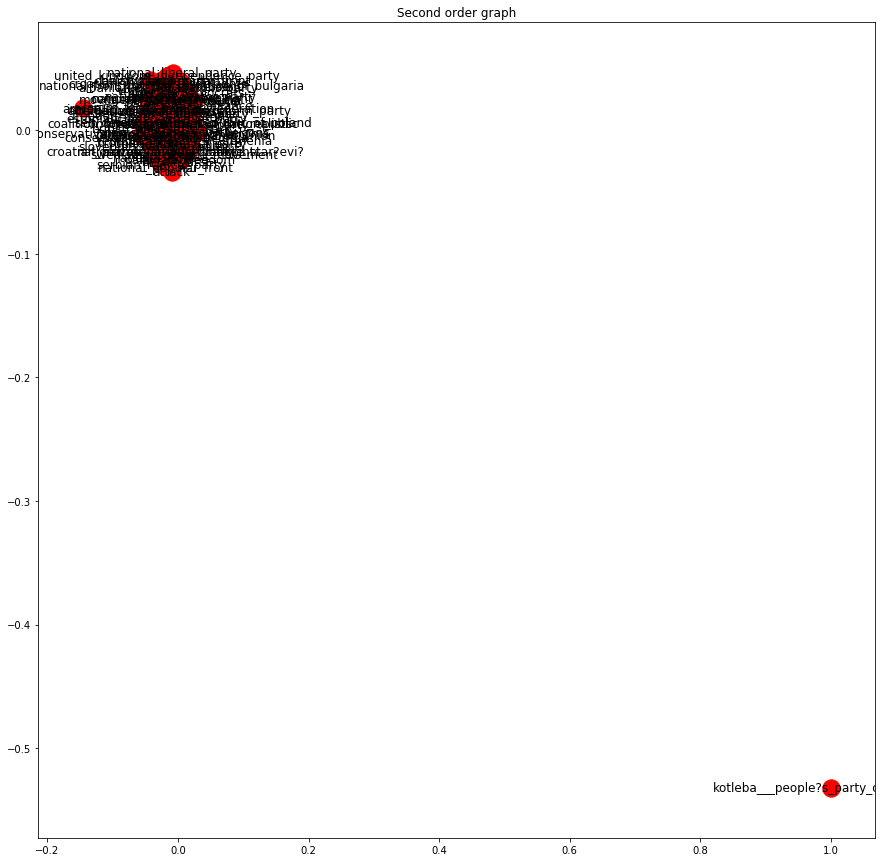

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

layout = nx.spring_layout

figure = plt.figure(figsize=(15, 15))
plt.title('First order graph')
pos = layout(graph_first)
nx.draw_networkx(graph_first, pos, with_labels=True)

figure = plt.figure(figsize=(15, 15))
pos = layout(graph_scnd)
plt.title('Second order graph')
nx.draw_networkx(graph_scnd, pos, with_labels=True)





# Basic Stats
We'll have a look at some basic stats for the graphs, like their size in terms of nodes and edges, the size of the GCC and the degree distribution.

Graph 1
Number of nodes: 70
Number of edges: 112
The average degree of the network is 3.2
The median degree of the network is 2.0
Number of nodes in GCC: 49
Graph 2
Number of nodes: 70
Number of edges: 2200
The average degree of the network is 62.857142857142854
The median degree of the network is 66.0
Number of nodes in GCC: 69


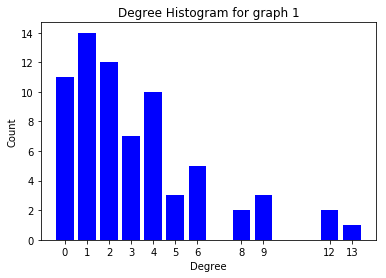

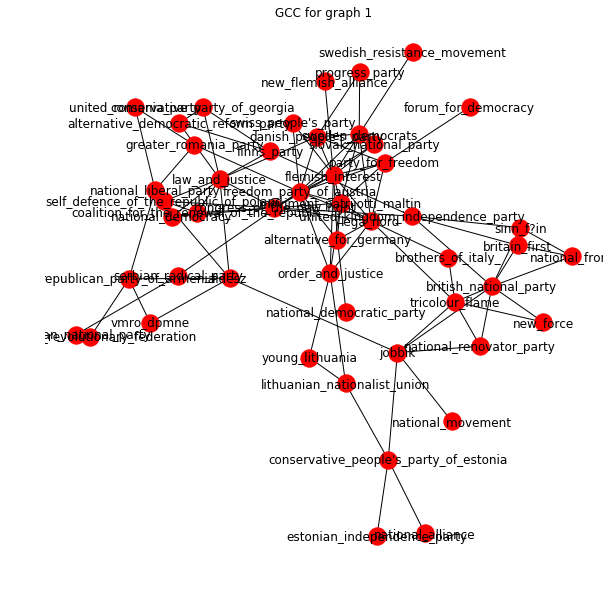

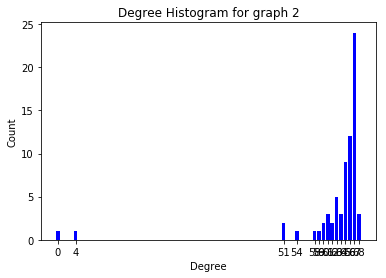

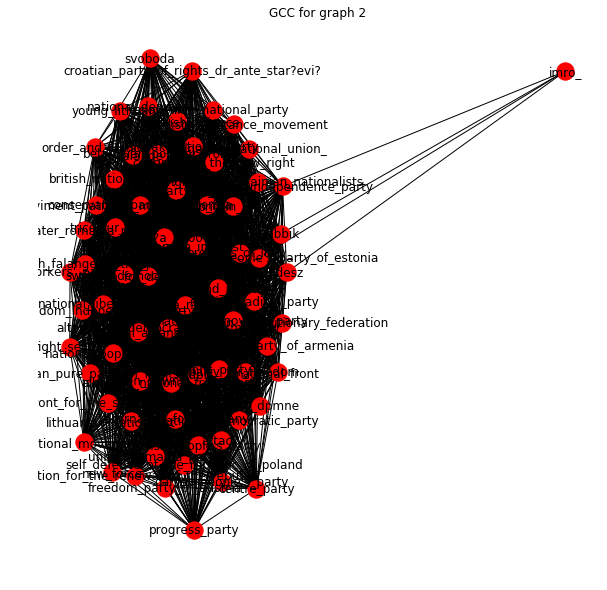

In [6]:
import numpy as np
from collections import Counter

for i, graph in enumerate([graph_first, graph_scnd]):
    print 'Graph', i + 1
    print 'Number of nodes:', len(graph.nodes)
    print 'Number of edges:', len(graph.edges)
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())    
    
    print 'The average degree of the network is', np.average(degree_sequence)
    print 'The median degree of the network is', np.median(degree_sequence)
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram for graph {}".format(i + 1))
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    G0 = Gcc[0]
    print 'Number of nodes in GCC:', len(G0.nodes)
    fig = plt.figure(figsize=(10, 10))
    plt.title('GCC for graph {}'.format(i + 1))
    pos = layout(G0)
    nx.draw(G0, pos, with_labels=True)


(u'euroscepticism', u'political_spectrum', u'international_standard_book_number', u'anti_communism', u'conservative_party_', u'digital_object_identifier')


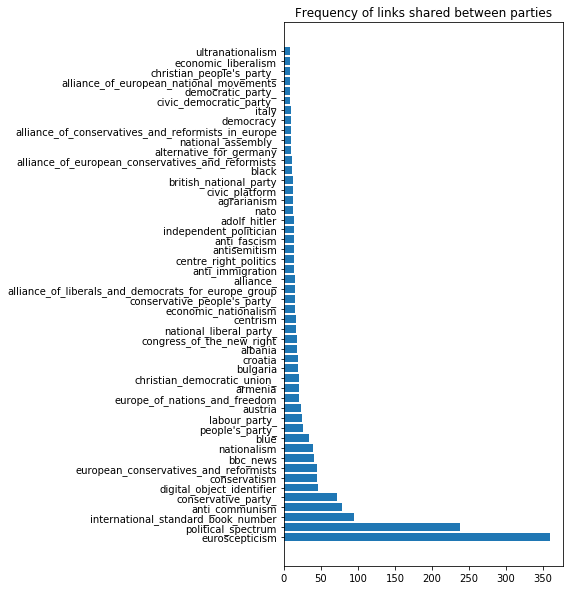

In [7]:
# linklist = map(lambda p: p['links'], parties)
# links = [link for links in linklist for link in links]

links  = sorted(nx.get_edge_attributes(graph_scnd, 'link').values())
links = [link.decode('utf-8') for link in links]
link_counts = Counter(links)


lnk, cnt = zip(*link_counts.most_common(50)) 
print lnk[0:6]
fig = plt.figure(figsize=(5, 10))

plt.barh(range(len(lnk)),cnt)
plt.yticks(range(len(lnk)),lnk)
plt.title('Frequency of links shared between parties')
plt.show()


# Color Coded Vizualization
A distinct set of colors is used for every country to color the parties taken from http://phrogz.net/css/distinct-colors.html.

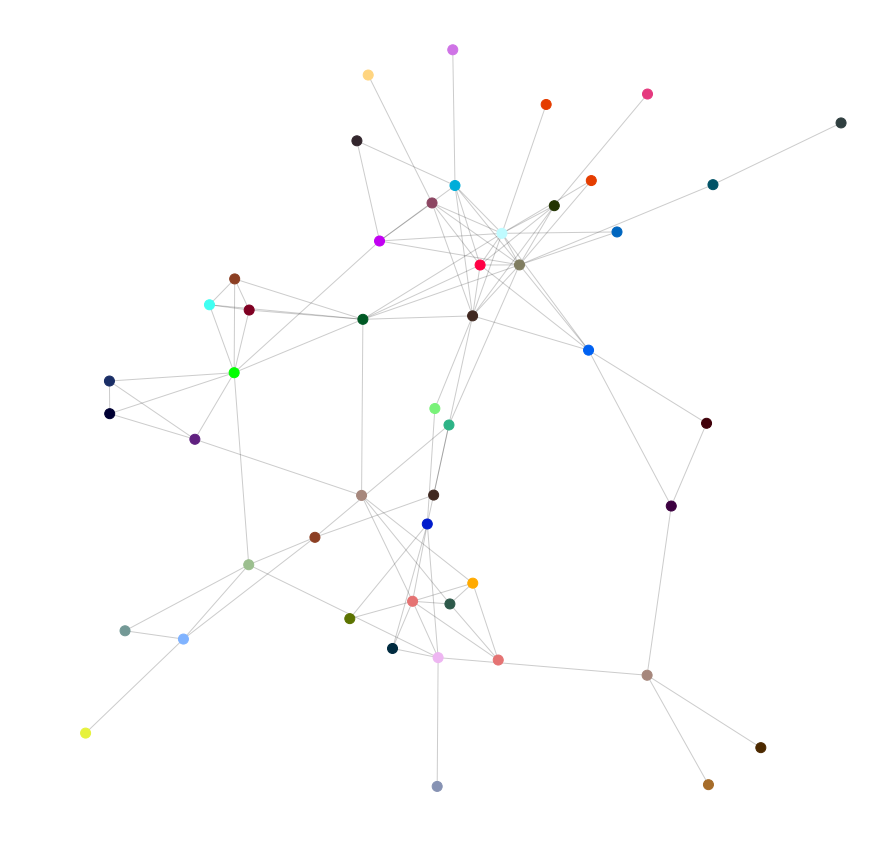

In [8]:
countries = set([str(d['Country']) for d in parties])
with open('data/colors.txt') as infile:
    colors = [s.strip() for s in infile.read().split(',')]

color_country = dict(zip(countries, colors))
def draw_color_net (graph):
    nodes = graph.nodes()

    node_colors = [color_country[str(graph.node[n]['Country'])] for n in nodes]
    fig = plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph)
    ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=colors, with_labels=True,
                                node_size=100, cmap=plt.cm.jet)
#     plt.colorbar(nc)
    plt.axis('off')
    plt.show()
    
Gcc_first = sorted(nx.connected_component_subgraphs(graph_first), key=len, reverse=True)
G0_first = Gcc_first[0]

draw_color_net(G0_first)

# Fascist Movements
Next, data is collected from https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country to complement the previous graphs. Only european movements are kept in, but for now we'll look at both acitve and inactive movements.

In [34]:
from bs4 import BeautifulSoup

# the pages are divided up per country according these lettergroups
divisions = ['A–F', 'G–M', 'N–T', 'U–Z']

# main article
fascist_list = 'List of fascist movements by country'

movements = []
# loop over 4 pages
for div in divisions:
    # get & parse HTML
    req = requests.get('https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country_' + div)
    soup = BeautifulSoup(req.content)
    table = soup.find('table')

    # collect entries in table
    for i, row in enumerate(table.findAll("tr")):
        # first row are headers, save as keys
        if i == 0:
            keys = [ele.text.strip() for ele in row.findAll('b')]
            keys.append('link')
        
        # parse out text of the cells and save the href
        else: 
            cells = [ele.text.strip() for ele in row.findAll("td")]
            link = row.find('a')
            if link:
                link = link.get('href')
            
            movement = dict(zip(keys, cells + [link]))
            movements.append(movement)

print 'Found', len(movements), 'movements'


A–F
https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country_A–F
https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country_A%E2%80%93F
Albania
Albania
Albania
Argentina
Argentina
Argentina
Argentina
Argentina
Argentina
Argentina
Argentina
Argentina
Australia
Australia
Australia
Australia
Australia
Austria
Austria
Austria
Austria
Austria
Belarus
Belgium
Belgium
Belgium
Belgium
Belgium
Belgium
Belgium
Belgium
Belgium
Bolivia
Bolivia
Bolivia
Brazil
Brazil
Brazil
Brazil
Bulgaria
Bulgaria
Bulgaria
Bulgaria
Bulgaria
Bulgaria
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Chile
Chile
Chile
Chile
Chile
Colombia
Croatia
Croatia
Cuba
Czechoslovakia
Czechoslovakia
Czechoslovakia
Czechoslovakia
Denmark
Denmark
Egypt
Finland
Finland
France
France
France
France (see History of the French far right)
France
France
France
France
France
G–M
https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country_G–M
https://en.wikipedia.org/wiki/List_of_fascist_moveme

In [35]:
# filter european movements
movements = filter(lambda m: any(c.lower() in m['Country of predominant operation'].lower() for c in countries), movements)
    
print 'There are', len(movements), 'movements in europe'

# fetch pages and parse links
for i, mov in enumerate(movements):
    mov['links'] = []
    try:
        page = wikipedia.page(mov['Name of movement'].encode('utf-8'))
        if page and mov['link']:
            mov['links'] = clean_links(page.links)
            print 'Found {} links for {}'.format(len(page.links), mov['Name of movement'].encode('utf-8'))
    except:
        print 'Failed to collect for {}'.format(mov['Name of movement'].encode('utf-8'))
    movements[i] = mov


There are 177 movements in europe
Found 448 links for Albanian Fascist Party
Found 448 links for Guard of Great Albania
Found 448 links for Albanian Nazi Party
Found 426 links for Austrian National Socialism
Found 506 links for National Democratic Party
Found 400 links for Patriotic Front (Austria)
Found 428 links for The Greens of Austria
Found 94 links for Working Group for Democratic Politics
Found 230 links for National Bolshevik Party-Belarus
Found 125 links for Jeune Europe
Found 12 links for Mouvement d'Action Civique
Found 38 links for Parti Communautaire Européen
Found 38 links for Parti Communautaire National-Européen
Found 444 links for Rexism
Found 251 links for Vlaamse Militanten Orde
Found 408 links for Verdinaso
Found 89 links for Flemish National Union
Found 67 links for De Vlag
Found 24 links for Bulgarian National Union - New Democracy
Found 354 links for Bulgarian National Socialist Workers Party
Found 350 links for National Social Movement
Found 355 links for Union 

Found 543 links for National Socialist Movement (Colin Jordan)
Found 1031 links for National Socialist Movement
Found 178 links for Nationalist Alliance
Found 527 links for New British Union
Failed to collect for New Party
Found 554 links for November 9th Society
Found 279 links for Official National Front
Found 231 links for Political Soldier
Found 490 links for Racial Volunteer Force
Found 335 links for Union Movement
Found 224 links for White Defence League
Found 219 links for White Nationalist Party


In [37]:
# graphs
fascist_first = nx.Graph()
fascist_biparte = nx.Graph()

for mov in movements:
    mov['title'] = clean_name(mov['Name of movement'].encode('utf-8'))
    # add nodes to both graphs
    fascist_first.add_node(mov['title'], **dict(mov))
    fascist_biparte.add_node(mov['title'], **dict(mov))

    
for i, mov in enumerate(movements):
    links = mov['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if fascist_first.has_node(clean_link):
            fascist_first.add_edge(clean_link, mov['title'])
        for j, mov2 in enumerate(movements):
            # add an edge if two party's pages have a link in commonn to 'second'
            if i != j:
                links2 = mov2['links']
                for link2 in links2:
                    if link == link2 and not fascist_biparte.has_edge(mov2['title'], mov['title']):
                        fascist_biparte.add_edge(mov2['title'], mov['title'], link=clean_link)



Graph 1
Number of nodes: 176
Number of edges: 1819
The average degree of the network is 20.670454545454547
The median degree of the network is 19.0
Number of nodes in GCC: 146
Graph 2
Number of nodes: 176
Number of edges: 11935
The average degree of the network is 135.625
The median degree of the network is 155.0
Number of nodes in GCC: 163


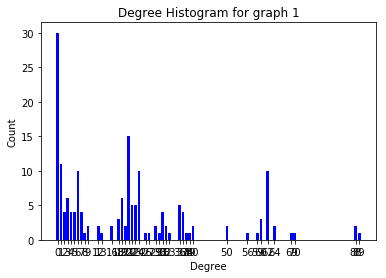

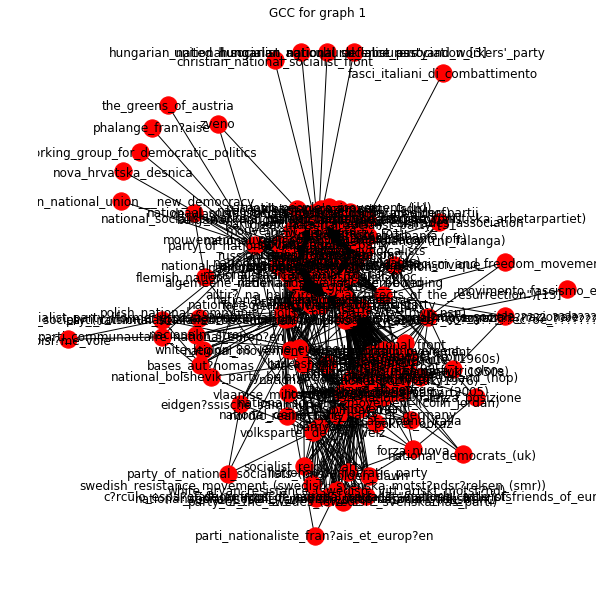

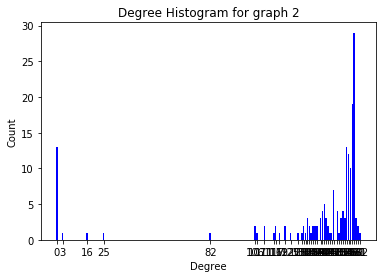

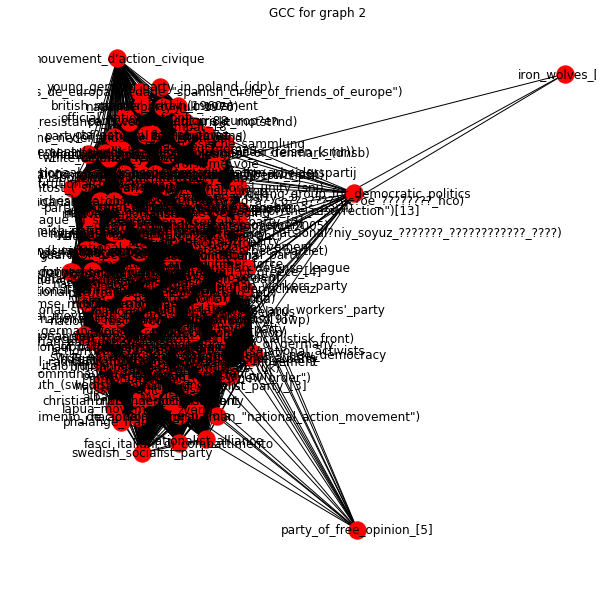

In [38]:
for i, graph in enumerate([fascist_first, fascist_biparte]):
    print 'Graph', i + 1
    print 'Number of nodes:', len(graph.nodes)
    print 'Number of edges:', len(graph.edges)
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())    
    
    print 'The average degree of the network is', np.average(degree_sequence)
    print 'The median degree of the network is', np.median(degree_sequence)
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram for graph {}".format(i + 1))
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    G0 = Gcc[0]
    print 'Number of nodes in GCC:', len(G0.nodes)
    fig = plt.figure(figsize=(10, 10))
    plt.title('GCC for graph {}'.format(i + 1))
    pos = layout(G0)
    nx.draw(G0, pos, with_labels=True)

(u'1934_montreux_fascist_conference', u'adolf_hitler', u'afrikaner_weerstandsbeweging', u'a_k_chesterton', u'british_fascists', u'anti_communism')


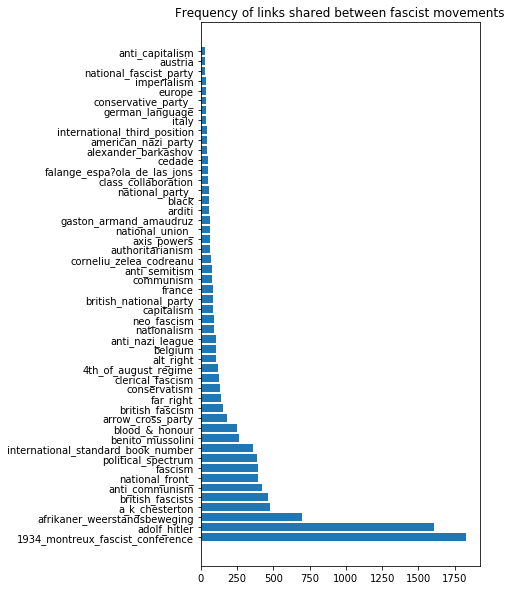

In [39]:
links  = sorted(nx.get_edge_attributes(fascist_biparte, 'link').values())
links = [link.decode('utf-8') for link in links]
link_counts = Counter(links)


lnk, cnt = zip(*link_counts.most_common(50)) 
print lnk[0:6]
fig = plt.figure(figsize=(5, 10))

plt.barh(range(len(lnk)),cnt)
plt.yticks(range(len(lnk)),lnk)
plt.title('Frequency of links shared between fascist movements')
plt.show()

# Build Network in Neo4j

Neo4j is used to build out a network structure that is provides a more expressive and flexible query language that we can leverage to explore the structure of the collected data. Nodes in this network are both the found 'Party's and the 'Movement's and edges ('LINKS_TO' relations) are created between all of these if their page links to either a 'Movement' or a 'Party'. With the query language Cypher we can then easily run queries on the network.

In [41]:
from neo4j.v1 import GraphDatabase

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "dodadoda"))

def add_party(tx, party):
    seats_total = total=party['Seats'].split()
    if len(seats_total) == 3:
        seats = seats_total[0]
        total = seats_total[1]
    else:
        seats = 'none'
        total = 'none'
    
    return tx.run("MERGE (a:Party {title: $title, name: $name, country: $country, votes: $votes, "
           "seats: $seats, total: $total, established: $established})",
           name=party['Party'], title=party['title'], country=party['Country'], votes=party['Votes'],
          seats=seats, total=total, established=party['Date established'])

def add_movement(tx, movement):
    try:
        influence = movement['General influence']
    except KeyError:
        influence = 'none'
    return tx.run("MERGE (b:Movement {title: $title, name: $name, country: $country, active: $active, influence: $influence})",
                 name=movement['Name of movement'], title=movement['title'], 
                  country=movement['Country of predominant operation'], 
                  active=movement['Active?'], influence=influence)
    
def add_link(tx, node, link):
    link = clean_name(link)
    # add an edge if a page of one party mentions another to 'first'
    result = tx.run('MATCH (n), (m) WHERE n.title = $title_a AND m.title = $title_b MERGE (n)-[:LINKS_TO]->(m)', 
           title_a=node, title_b=link)
    
def find_node(tx, name, type_):
    title = clean_name(name)
    return list(tx.run("MATCH (a:{}) WHERE a.title = $title RETURN a.title AS title".format(type_),title=title))


with driver.session() as session:
    # add party nodes
    for party in parties:
        session.write_transaction(add_party, wiki_table_sanitizer(party))
    print 'Added {} parties to network'.format(len(list(parties)))
    
    # add movement nodes
    for mov in movements:
        session.write_transaction(add_movement, mov)
    print 'Added {} movements to network'.format(len(movements))
    
    # look up the links from all parties within network and create edges
    for party in parties:
        for link in party['links']:
            parties_ = session.read_transaction(find_node, link, 'Party')
            if len(parties_) > 0:
                session.write_transaction(add_link, wiki_table_sanitizer(party)['title'], link)
            movs = session.read_transaction(find_node, link, 'Movement')
            if len(movs) > 0:
                session.write_transaction(add_link, wiki_table_sanitizer(party)['title'], link)
    
    # look up links from all movements within network and create edges
    for mov in movements:
        for link in mov['links']:
            parties_ = session.read_transaction(find_node, link, 'Party')
            if len(parties_) > 0:
                session.write_transaction(add_link, mov['title'], link)
            movs = session.read_transaction(find_node, link, 'Movement')
            if len(movs) > 0:
                session.write_transaction(add_link, mov['title'], link)


Added 70 parties to network
Added 177 movements to network


# Network Analysis

## Nodes & Edges
Now that all the network data is stored in one central place, Neo4j is used to look at some statistics about the network. First, we look at some basic stats about the nodes and edges in the network:


In [50]:
with driver.session() as session:
    print 'General Stats'
    # number of nodes
    result = session.run("MATCH (n) RETURN count(n)")
    values = result.value()
    print 'There are {} Nodes in the network'.format(values[0])
    
    # number of edges
    result = session.run("MATCH (n)-[r:LINKS_TO]->(m) RETURN count(r)")
    values = result.value()
    print  'There are {} links between Nodes in the network'.format(values[0])
    
    result = session.run("MATCH (n:Party)-[r:LINKS_TO]->(m:Movement) RETURN n, r, m")
    records = list(result.records())
    n, r, m = set(), set(), set()
    for rec in records: 
        n.add(rec['n'])
        r.add(rec['r'])
        m.add(rec['m'])
    print 'There are {} "Party" nodes linking to {} "Movement" nodes through {} edges'.format( len(n), len(m), len(r))
    
    result = session.run("MATCH (n:Movement)-[r:LINKS_TO]->(m:Party) RETURN n, r, m")
    records = list(result.records())
    n, r, m = set(), set(), set()
    for rec in records: 
        n.add(rec['n'])
        r.add(rec['r'])
        m.add(rec['m'])
    print 'There are {} "Movement" nodes linking to {} "Party" nodes through {} edges'.format( len(n), len(m), len(r))
    
    print '\nParties Stats'
    # number of nodes
    result = session.run("MATCH (n:Party) RETURN count(n)")
    values = result.value()
    print 'There are {} "Party" nodes in the network'.format(values[0])
    
    # number of edges
    result = session.run("MATCH (n:Party)-[r:LINKS_TO]->(m:Party) RETURN count(r)")
    values = result.value()
    print  'There are {} links between "Party" nodes in the network'.format(values[0])
    
    print '\nMovements Stats'
    # number of nodes
    result = session.run("MATCH (n:Movement) RETURN count(n)")
    values = result.value()
    print 'There are {} "Movement" nodes in the network'.format(values[0])
    
    # number of edges
    result = session.run("MATCH (n:Movement)-[r:LINKS_TO]->(m:Movement) RETURN count(r)")
    values = result.value()
    print  'There are {} links between "Movement" nodes in the network'.format(values[0])
    
    

General Stats
There are 247 Nodes in the network
There are 2813 links between Nodes in the network
There are 27 "Party" nodes linking to 48 "Movement" nodes through 150 edges
There are 88 "Movement" nodes linking to 24 "Party" nodes through 181 edges

Parties Stats
There are 70 "Party" nodes in the network
There are 153 links between "Party" nodes in the network

Movements Stats
There are 177 "Movement" nodes in the network
There are 2329 links between "Movement" nodes in the network


## Centrality Measures
### Degree Distribution

Next, we will consider a series of stats that express the connectednes of the entities in our network. First, we look at the in- and outdegree of the nodes, for the network as a whole and for the Party & Movement network seperatetly. This shows how many pages link to a Party or Movement, and to how many other nodes the page of a node links, respectively. 

In [51]:
variables = [{
    'entity': '',
    'text': 'General Stats'
}, {
    'entity': ':Party',
    'text': 'Parties Stats'
}, {
    'entity': ':Movement',
    'text': 'Movements Stats'
}]

with driver.session() as session:
    for net in variables:
        print '\n' + net['text']
        print 'In-Degree'
        result = session.run("MATCH (l{}) RETURN l.name as Name, l.country as Country, size ((l)<-[:LINKS_TO]-())"
                             "AS in_degree ORDER BY in_degree DESC limit 10".format(net['entity']))
        for rec in result.records():
            print ' - {}, {}: {}'.format(rec['Name'].encode('utf-8'), rec['Country'], rec['in_degree'])
        
        print '\nOut-Degree'
        result = session.run("MATCH (l{}) RETURN l.name as Name, l.country as Country, size ((l)-[:LINKS_TO]->())"
                             "AS out_degree ORDER BY out_degree DESC limit 10".format(net['entity']))
        for rec in result.records():
            print ' - {}, {}: {}'.format(rec['Name'].encode('utf-8'), rec['Country'], rec['out_degree'])
    


General Stats
In-Degree
 - British Union of Fascists, United Kingdom: 94
 - Imperial Fascist League, United Kingdom: 94
 - National Fascisti, United Kingdom: 94
 - Iron Guard, Romania: 75
 - Arrow Cross Party, Hungary: 72
 - National Corporate Party, Ireland: 66
 - Ustaše, Croatia: 66
 - Romanian Front, Romania: 65
 - Crusade of Romanianism, Romania: 65
 - Austrian National Socialism, Austria: 65

Out-Degree
 - British Nazi Party, United Kingdom: 44
 - Party of National Unity (SNJ), Czechoslovakia: 40
 - Groupe Charles Martel, France: 40
 - National Socialist League, United Kingdom: 40
 - British Fascisti, United Kingdom: 39
 - Russian National Socialist Party (formerly Russian National Union) (Russkiy Natsionalʼniy Soyuz Русский Национальний Союз), Russia: 38
 - Polish National Community-Polish National Party (PWN-PSN), Poland: 38
 - National Socialist Society (Natsional-sotsialisticheskoye obshchestvo, NSO, нaциoнaл-coциaлстичecкoe общество, HCO), Russia: 38
 - British People's Part

Now, we'll look into the Nationalistic Parties that have ties with Fascist Movements.

In [52]:
with driver.session() as session:
    print 'Nationalist Parties that link to Fascist Movements'
    result = list(session.run('MATCH (n:Party)-[r:LINKS_TO]->(m:Movement) RETURN n, r, m').records())
    title = result[0]['n']['title']
    print '{} ({}, {})'.format(            
            result[0]['n']['title'], 
            result[0]['n']['country'],
            result[0]['n']['established'],)
    for record in result:
        if record['n']['title'] == title:
            print ' -> {} ({}) Active: {}'.format(
            record['m']['title'], 
            record['m']['country'],
            record['m']['active'])
        else:
            title = record['n']['title']
            print '\n{} ({}, {})'.format(            
            record['n']['title'], 
            record['n']['country'],
            record['n']['established'],)
            
    print '\n\nFascist Movements that link to Nationalist Parties'
    result = list(session.run('MATCH (n:Party)<-[r:LINKS_TO]-(m:Movement) RETURN n, r, m').records())
    title = result[0]['n']['title']
    print '{} ({}, {})'.format(            
            result[0]['n']['title'], 
            result[0]['n']['country'],
            result[0]['n']['established'],)
    for record in result:
        if record['n']['title'] == title:
            print ' <- {} ({}) Active: {}'.format(
            record['m']['title'], 
            record['m']['country'],
            record['m']['active'])
        else:
            title = record['n']['title']
            print '\n{} ({}, {})'.format(            
            record['n']['title'], 
            record['n']['country'],
            record['n']['established'],)
            


Nationalist Parties that link to Fascist Movements
sinn_f?in (Ireland, 1905)
 -> england_first_party (United Kingdom) Active: No
 -> british_national_party (United Kingdom) Active: Yes
 -> britain_first (United Kingdom) Active: Yes

national_front (France, 1972)
 -> union_movement (United Kingdom) Active: No
 -> racial_volunteer_force (United Kingdom) Active: Yes
 -> political_soldier (United Kingdom) Active: No
 -> official_national_front (United Kingdom) Active: No
 -> november_9th_society (United Kingdom) Active: Yes
 -> national_fascisti (United Kingdom) Active: No
 -> italian_social_movement (Italy) Active: No
 -> imperial_fascist_league (United Kingdom) Active: No
 -> greater_britain_movement (United Kingdom) Active: No
 -> flag_group (United Kingdom) Active: No
 -> england_first_party (United Kingdom) Active: No
 -> constitutional_movement (United Kingdom) Active: No
 -> combat_18 (United Kingdom) Active: Yes
 -> british_union_of_fascists (United Kingdom) Active: No
 -> british_

 <- british_union_of_fascists (United Kingdom) Active: No
 <- british_people's_party_(1939) (United Kingdom) Active: No
 <- british_people's_party_(2005) (United Kingdom) Active: No
 <- british_nazi_party (United Kingdom) Active: ?
 <- british_national_party_(1960s) (United Kingdom) Active: No
 <- british_national_front (United Kingdom) Active: Yes
 <- british_movement (United Kingdom) Active: No
 <- british_fascisti (United Kingdom) Active: No
 <- britain_first (United Kingdom) Active: Yes
 <- blood_and_honour (United Kingdom) Active: Yes
 <- pamyat (Russia) Active: No
 <- noua_dreapt? (Romania) Active: Yes
 <- forza_nuova (Italy) Active: Yes
 <- fiamma_tricolore (Italy) Active: Yes
 <- casapound_italia (Italy) Active: Yes
 <- parti_nationaliste_fran?ais_et_europ?en (France) Active: No

britain_first (United Kingdom, 2011)
 <- national_front (Switzerland) Active: No
 <- white_nationalist_party (United Kingdom) Active: No
 <- white_defence_league (United Kingdom) Active: No
 <- union_m

Then, we will look at the betweenness centrality of the Party's and Movements, which expresses how much information flows through a node by looking at how many shortest paths of the whole network pass through it. The algrothms have been run within the Neo4j browser using https://neo4j-contrib.github.io/neo4j-graph-algorithms/ and cached on the graph model within the database.

In [227]:
with driver.session() as session:
    print 'Top 10 Parties in terms of Betweenness Centrality among Parties'
    result = session.run("MATCH (l:Party) "
    "WHERE EXISTS (l.all_party_betweenness) "
    "RETURN l.name as name, l.country as country, l.all_party_betweenness as betweenness, "
    "toFloat(l.seats) / toFloat(l.total) as fraction "
    "ORDER BY betweenness DESC LIMIT 10")
    result = list(result.records())
    for rec in result:
        print ' - {}, {} - centrality: {} - fraction {}'.format(rec['name'].encode('utf-8'), rec['country'], rec['betweenness'], rec['fraction'])
    
    print '\nTop 10 Movement in terms of Betweenness Centrality among Movements'
    result = session.run("MATCH (l:Movement) "
    "WHERE EXISTS (l.all_movement_betweenness) "
    "RETURN l.name as name, l.country as country, l.all_movement_betweenness as betweenness "
    "ORDER BY betweenness DESC LIMIT 10")
    result = list(result.records())
    for rec in result:
        print ' - {}, {} - centrality: {}'.format(rec['name'].encode('utf-8'), rec['country'], rec['betweenness'])
        
    print '\nTop 10 Movement in terms of Betweenness Centrality among ACTIVE Movements'
    result = session.run("MATCH (l:Movement) "
    "WHERE EXISTS (l.active_movement_betweenness) "
    "RETURN l.name as name, l.country as country, l.active_movement_betweenness as betweenness "
    "ORDER BY betweenness DESC LIMIT 10")
    result = list(result.records())
    for rec in result:
        print ' - {}, {} - centrality: {}'.format(rec['name'].encode('utf-8'), rec['country'], rec['betweenness'])
        
    print '\nTop 10 nodes in terms of Betweenness Centrality among all nodes'
    result = session.run("MATCH (l) "
    "WHERE EXISTS (l.all_betweenness) "
    "RETURN l.name as name, l.country as country, l.all_betweenness as betweenness, l.Label as label "
    "ORDER BY betweenness DESC LIMIT 10")
    result = list(result.records())
    for rec in result:
        print ' - {}, {}: {}'.format(rec['name'].encode('utf-8'), rec['country'], rec['betweenness'])

Top 10 Parties in terms of Betweenness Centrality among Parties
 - Law and Justice, Poland - centrality: 476.5 - fraction 0.510869565217
 - Jobbik, Hungary - centrality: 413.0 - fraction 0.130653266332
 - Fidesz, Hungary - centrality: 412.0 - fraction 0.673366834171
 - Lega Nord, Italy - centrality: 354.0 - fraction 0.198412698413
 - Tricolour Flame, Italy - centrality: 337.0 - fraction 0.0
 - Freedom Party of Austria, Austria - centrality: 288.333333333 - fraction 0.27868852459
 - Congress of the New Right, Poland - centrality: 196.0 - fraction 0.0
 - British National Party, United Kingdom - centrality: 159.0 - fraction 0.0
 - Danish People's Party, Denmark - centrality: 136.0 - fraction 0.206703910615
 - Greater Romania Party, Romania - centrality: 51.0 - fraction 0.0

Top 10 Movement in terms of Betweenness Centrality among Movements
 - British Union of Fascists, United Kingdom - centrality: 900.649332688
 - Imperial Fascist League, United Kingdom - centrality: 876.253318195
 - Nati

We can use these centrality measures (degree & betweenness) to give some legitimacy to the network, by looking at the correlation between those measures and the size of the party in terms of votes.

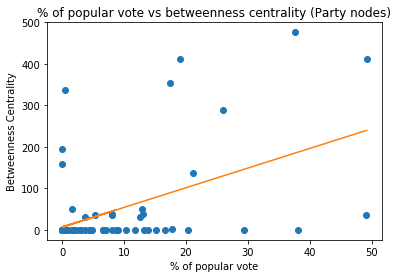

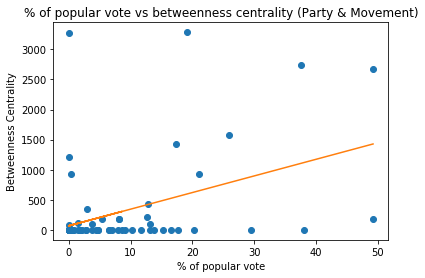

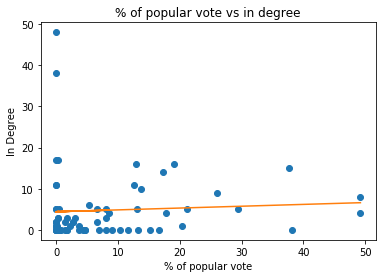

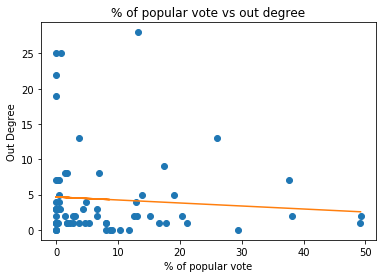

In [65]:
from scipy import stats

# parse out figures for popular vote
for i, party in enumerate(parties): 
    try:
        fraction_votes = float(str(party['% of popular vote']).split('%')[0])
        parties[i]['fraction_votes'] = fraction_votes
    except:
        parties[i]['fraction_votes'] = 0
        
with driver.session() as session:
    # centrality
    result = session.run("MATCH (l:Party) "
    "WHERE EXISTS (l.all_party_betweenness) "
    "RETURN l.name as name, l.title as title, l.country as country, l.all_party_betweenness as betweenness "
    "ORDER BY betweenness DESC")
    result = list(result.records())
    for record in result:
        party = next((x for x in parties if x['title'] == str(record['title'])), None)
        party['all_party_betweenness'] = record['betweenness']
    
    result = session.run("MATCH (l:Party) "
    "WHERE EXISTS (l.all_party_betweenness) "
    "RETURN l.name as name, l.title as title, l.country as country, l.all_betweenness as betweenness "
    "ORDER BY betweenness DESC")
    result = list(result.records())
    for record in result:
        party = next((x for x in parties if x['title'] == record['title']), None)
        party['all_betweenness'] = record['betweenness']
    
    # in degree
    result = session.run("MATCH (l:Party) RETURN l.name as Name, l.title as title, l.country as Country, size((l)<-[:LINKS_TO]-())"
                             "AS in_degree ORDER BY in_degree DESC")
    result = list(result.records())
    for record in result:
        party = next((x for x in parties if x['title'] == record['title']), None)
        party['in_degree'] = record['in_degree']
    
    # out degree
    result = session.run("MATCH (l:Party) RETURN l.name as Name, l.title as title, l.country as Country, size((l)-[:LINKS_TO]->())"
                             "AS out_degree ORDER BY out_degree DESC")
    result = list(result.records())
    for record in result:
        party = next((x for x in parties if x['title'] == record['title']), None)
        party['out_degree'] = record['out_degree']

# create separate arrays 
fractions = np.array(map(lambda x: x['fraction_votes'], parties))
betweenness = np.array(map(lambda x: x['all_party_betweenness'], parties))
all_betweenness = np.array(map(lambda x: x['all_betweenness'], parties))
in_degree = np.array(map(lambda x: x['in_degree'], parties))
out_degree = np.array(map(lambda x: x['out_degree'], parties))

# linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(fractions, betweenness)
line = slope * fractions + intercept

plt.title('% of popular vote vs betweenness centrality (Party nodes)')
plt.xlabel('% of popular vote')
plt.ylabel('Betweenness Centrality')
plt.plot(fractions, betweenness,'o', fractions, line)
plt.show()

# linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(fractions, all_betweenness)
line = slope * fractions + intercept

plt.title('% of popular vote vs betweenness centrality (Party & Movement)')
plt.xlabel('% of popular vote')
plt.ylabel('Betweenness Centrality')
plt.plot(fractions, all_betweenness,'o', fractions, line)
plt.show()

# linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(fractions, in_degree)
line = slope * fractions + intercept

plt.title('% of popular vote vs in degree')
plt.xlabel('% of popular vote')
plt.ylabel('In Degree')
plt.plot(fractions, in_degree,'o', fractions, line)
plt.show()

# linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(fractions, out_degree)
line = slope * fractions + intercept

plt.title('% of popular vote vs out degree')
plt.xlabel('% of popular vote')
plt.ylabel('Out Degree')
plt.plot(fractions, out_degree,'o', fractions, line)
plt.show()

In [66]:
import pandas as pd

df = pd.DataFrame(parties)
display(df)

% of popular vote         Country Date established  \
0                   49.21% ( 2018 )         Hungary             1988   
1                   49.17% ( 2017 )         Armenia             1990   
2                    38.1% ( 2016 )       Macedonia             1990   
3                    37.6% ( 2015 )          Poland             2001   
4                    29.4% ( 2015 )     Switzerland             1971   
5                    26.0% ( 2017 )         Austria             1956   
6                    21.1% ( 2015 )         Denmark             1995   
7                    20.3% ( 2014 )         Belgium             2001   
8                   19.06% ( 2018 )         Hungary             2003   
9                    17.7% ( 2015 )         Finland             1995   
10                  17.37% ( 2018 )           Italy             1991   
11                   16.6% ( 2014 )          Latvia             2010   
12                   15.2% ( 2017 )          Norway             1973   
13                   13.8% ( 2016 )         Ireland             1905   
14                  13.20% ( 2017 )          France             1972   
15                   13.1% ( 2017 )     Netherlands             2006   
16                   12.9% ( 2014 )          Sweden             1988   
17                   12.6% ( 2017 )         Germany             2013   
18                   11.7% ( 2016 )          Russia             1991   
19                   10.3% ( 2017 )          Norway             1920   
20                     9.07% (2017)        Bulgaria             1999   
21                     9 240 red \t        Bulgaria             2011   
22                     7 240 red \t        Bulgaria             2005   
23                   8.64% ( 2016 )        Slovakia             1989   
24                    8.1% ( 2015 )         Estonia             2012   
25                    8.1% ( 2016 )          Serbia             1991   
26                   8.04% ( 2016 )        Slovakia             2011   
27                   6.99% ( 2015 )          Greece             1993   
28                    6.6% ( 2013 )      Luxembourg             1987   
29                    6.6% ( 2017 )         Armenia             1890   
..                              ...             ...              ...   
40                    2.2% ( 2014 )        Slovenia             1991   
41                    1.8% ( 2014 )         Ukraine             2014   
42                    1.8% ( 2017 )  United Kingdom             1993   
43                   1.78% ( 2017 )     Netherlands             2016   
44                    1.5% ( 2013 )         Germany             1964   
45                    1.5% ( 2012 )         Romania             1991   
46                   0.86% ( 2013 )  Czech Republic             2010   
47                     0.54% (2016)       Lithuania             1924   
48                     0 141 red \t       Lithuania             2009   
49                   0.50% ( 2015 )        Portugal             2000   
50                   0.43% ( 2014 )         Moldova             1993   
51                   0.36% ( 2017 )           Malta             2016   
52                   0.28% ( 2013 )         Albania             1989   
53                   0.38% ( 2018 )           Italy             1997   
54                   0.18% ( 2015 )         Estonia             1999   
55                   0.17% ( 2014 )        Bulgaria             2014   
56                   0.38% ( 2018 )           Italy             1995   
57                   0.05% ( 2014 )         Ukraine             1992   
58                   0.04% ( 2016 )           Spain             1976   
59                   0.04% ( 2011 )           Spain             2002   
60                   0.03% ( 2015 )          Poland             2011   
61                   0.03% ( 2015 )          Poland             1992   
62                   0.01% ( 2011 )           Spain             1995   
63                   0.00% ( 2017 )  United Kingdom       

In [67]:
# clean up data
def split_seats (s, idx):
    try:
        return int(str(s).split()[idx])
    except:
        return 0

df['total'] = df.apply(lambda row: split_seats(row['Seats'], 1), axis = 1)
df['seats'] = df.apply(lambda row: split_seats(row['Seats'], 0), axis = 1)
df['country'] = df.apply(lambda row: str(row['Country']), axis=1)


In [68]:
print 'Top ten countries in terms of centrality between parties'
print df.groupby('country')['all_party_betweenness'].mean().sort_values( ascending=False)[0:10]

print '\nTop ten countries in terms of centrality between parties and movements'
print df.groupby('country')['all_betweenness'].mean().sort_values( ascending=False)[0:10]

Top ten countries in terms of centrality between parties
country
Hungary           412.500000
Austria           288.333333
Italy             172.750000
Denmark           136.000000
Poland            134.500000
United Kingdom     53.000000
Serbia             37.000000
Romania            25.500000
Sweden             24.666667
Estonia            19.500000
Name: all_party_betweenness, dtype: float64

Top ten countries in terms of centrality between parties and movements
country
Hungary           2979.917122
Austria           1577.898631
United Kingdom    1120.070157
Denmark            930.632201
Poland             791.624469
Italy              588.627875
Sweden             221.152525
Serbia             176.000000
Croatia            116.666667
Germany            104.504889
Name: all_betweenness, dtype: float64


In [221]:
print 'Top ten countries in terms of in degree of parties'
print df.groupby('country')['in_degree'].mean().sort_values( ascending=False)[0:10]

print 'Top ten countries in terms of out degree of parties'
print df.groupby('country')['out_degree'].mean().sort_values( ascending=False)[0:10]


Top ten countries in terms of in degree of parties
country
United Kingdom    28.666667
Hungary           12.000000
Sweden            10.500000
Ireland           10.000000
Austria            9.000000
Poland             8.600000
Italy              7.750000
Germany            5.500000
Switzerland        5.000000
Denmark            5.000000
Name: in_degree, dtype: float64
Top ten countries in terms of out degree of parties
country
France            28.000000
Czech Republic    25.000000
United Kingdom    17.333333
Austria           13.000000
Greece             8.000000
Belgium            7.500000
Malta              7.000000
Spain              6.500000
Italy              5.500000
Sweden             5.500000
Name: out_degree, dtype: float64

Top ten countries in terms of centrality between parties and movements
country
Hungary           2979.917122
Austria           1577.898631
United Kingdom    1120.070157
Denmark            930.632201
Poland             791.624469
Italy              588.627

# Community Detection

In order to see how the different nationalistic Parties and fascist movements relate to eachother, we'll look into communities within the graph - sets of nodes or subgraphs within the network that have a stronger connection to eachother than to the rest of the network. The louvain algorithm is used within Neo4j and the Infomap algorithm is used with the NetworkX representation.

In [139]:
from infomap import infomap
import matplotlib.colors as colors

with open('data/colors.txt') as infile:
    colors_light = [s.strip() for s in infile.read().split(',')]
    
def clamp(val, minimum=0, maximum=255):
    if val < minimum:
        return minimum
    if val > maximum:
        return maximum
    return val

def colorscale(hexstr, scalefactor):
    """
    Scales a hex string by ``scalefactor``. Returns scaled hex string.

    To darken the color, use a float value between 0 and 1.
    To brighten the color, use a float value greater than 1.

    >>> colorscale("#DF3C3C", .5)
    #6F1E1E
    >>> colorscale("#52D24F", 1.6)
    #83FF7E
    >>> colorscale("#4F75D2", 1)
    #4F75D2
    """

    hexstr = hexstr.strip('#')

    if scalefactor < 0 or len(hexstr) != 6:
        return hexstr

    r, g, b = int(hexstr[:2], 16), int(hexstr[2:4], 16), int(hexstr[4:], 16)

    r = clamp(r * scalefactor)
    g = clamp(g * scalefactor)
    b = clamp(b * scalefactor)

    return "#%02x%02x%02x" % (r, g, b)

colors_dark = [colorscale(hex_, 0.1) for hex_ in colors_light]


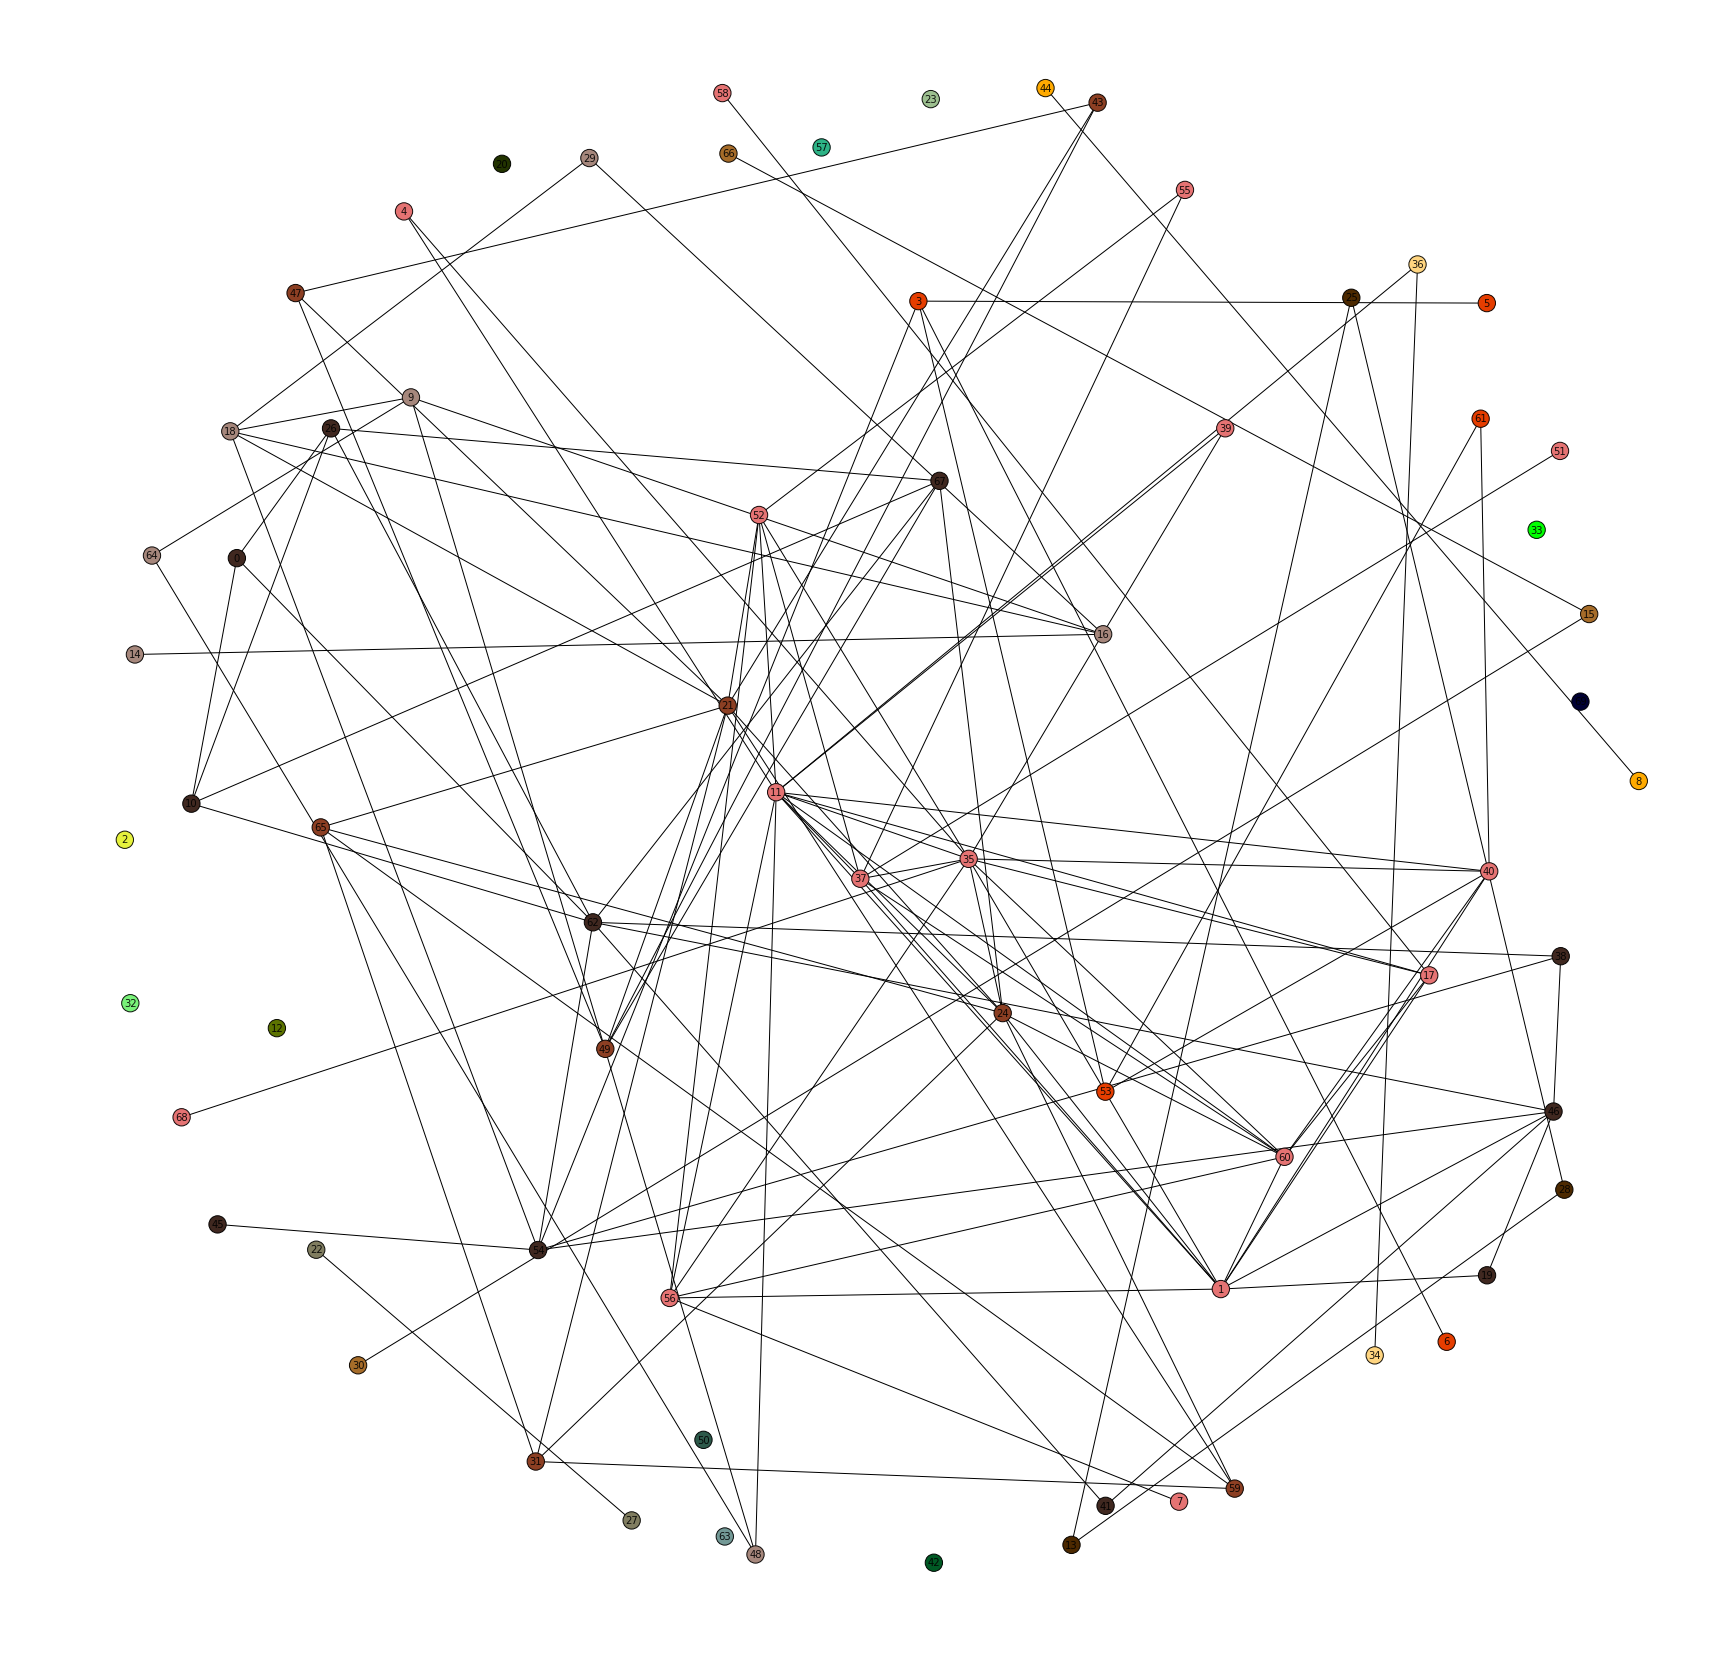

In [197]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = infomap.Infomap("--two-level --silent")

    print("Building Infomap network from a NetworkX graph...")
    
    for e in G.edges():
        infomapWrapper.addLink(e[0], e[1])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    tree = infomapWrapper.tree

    print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    communities = {}
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.moduleIndex()
    # set default
    for n in G.nodes:
        try:
            comm = communities[n]
        except KeyError:
            print 'Node {} has no community attribute, default to 1000'.format(n)
            G.nodes[n]['community'] = 1000
    nx.set_node_attributes(G, name='community', values=communities)
    return tree.numTopModules()

def drawNetwork(G):


    # position map
    pos = nx.spring_layout(G, k=1/ (0.01 * float(len(G.nodes))))
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(colors_light, 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(colors_dark, 'indexed', numCommunities)
    print cmapLight
    # Draw edges
    fig = plt.figure(figsize=(30, 30))
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )
    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

drawNetwork(graph_first_int)
# this one doesn't work... drawNetwork(graph_first_int)


In [196]:
# process the direct and bipartite graphs for the parties and the movements seperately
# create an integer labeled copy of our graphs
graph_first_int = nx.convert_node_labels_to_integers(graph_first, label_attribute='title')
graph_scnd_int = nx.convert_node_labels_to_integers(graph_scnd, label_attribute='title')

fascist_first_int = nx.convert_node_labels_to_integers(fascist_first, label_attribute='title')
fascist_biparte_int = nx.convert_node_labels_to_integers(fascist_biparte, label_attribute='title')


# find comminities with informap algorithm
for graph in [graph_first_int, graph_scnd_int, fascist_first_int, fascist_biparte_int]:
    findCommunities(graph)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 20 modules with codelength: 3.996045
Node 69 has no community attribute, default to 1000
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 2 modules with codelength: 6.090137
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 35 modules with codelength: 6.345101
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 14 modules with codelength: 7.323563


In [199]:
with driver.session() as session:
    for n in graph_first_int.nodes:
        node = graph_first_int.nodes[n]
        try:
            session.run('MATCH (n:Party) WHERE n.title = "{}" SET n.info_party_community = {}'.format(
                node['title'], 
                node['community']
            ))
        except KeyError:
            print node['title'], 'has no community'

    for n in fascist_first_int.nodes:
        node = fascist_first_int.nodes[n]
        try:
            if "'" in node['title']:
                session.run('MATCH (n:Movement) WHERE n.title = "{}" SET n.info_movement_community = {}'.format(
                node['title'], 
                node['community']
            ))
            else:
                session.run("MATCH (n:Movement) WHERE n.title = '{}' SET n.info_movement_community = {}".format(
                node['title'], 
                node['community']
            ))            
        except KeyError:
            print node['title'], 'has no community'

In [232]:
# build all connecting graph for Party nodes and Movement nodes in NetworkX

graph_all = nx.DiGraph()

# add party nodes
for party in parties:
    attributes = dict(wiki_table_sanitizer(party))
    attributes['label'] = 'party'
    graph_all.add_node(party['title'], **attributes)
print 'Added {} parties to network'.format(len(list(parties)))

# add movement nodes
for mov in movements:
    attributes = dict(mov)
    attributes['label'] = 'movement'
    graph_all.add_node(mov['title'], **attributes)
    
print 'Added {} movements to network'.format(len(movements))

for i, party in enumerate(parties):
    links = party['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if graph_all.has_node(clean_link):
            graph_all.add_edge(clean_link, party['title'])

for i, mov in enumerate(movements):
    links = mov['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if graph_all.has_node(clean_link):
            graph_all.add_edge(clean_link, mov['title'])

print 'graph_all has', len(graph_all.nodes), 'nodes and', len(graph_all.edges), 'edges'

Added 70 parties to network
Added 177 movements to network
graph_all has 239 nodes and 2448 edges


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 39 modules with codelength: 6.341909


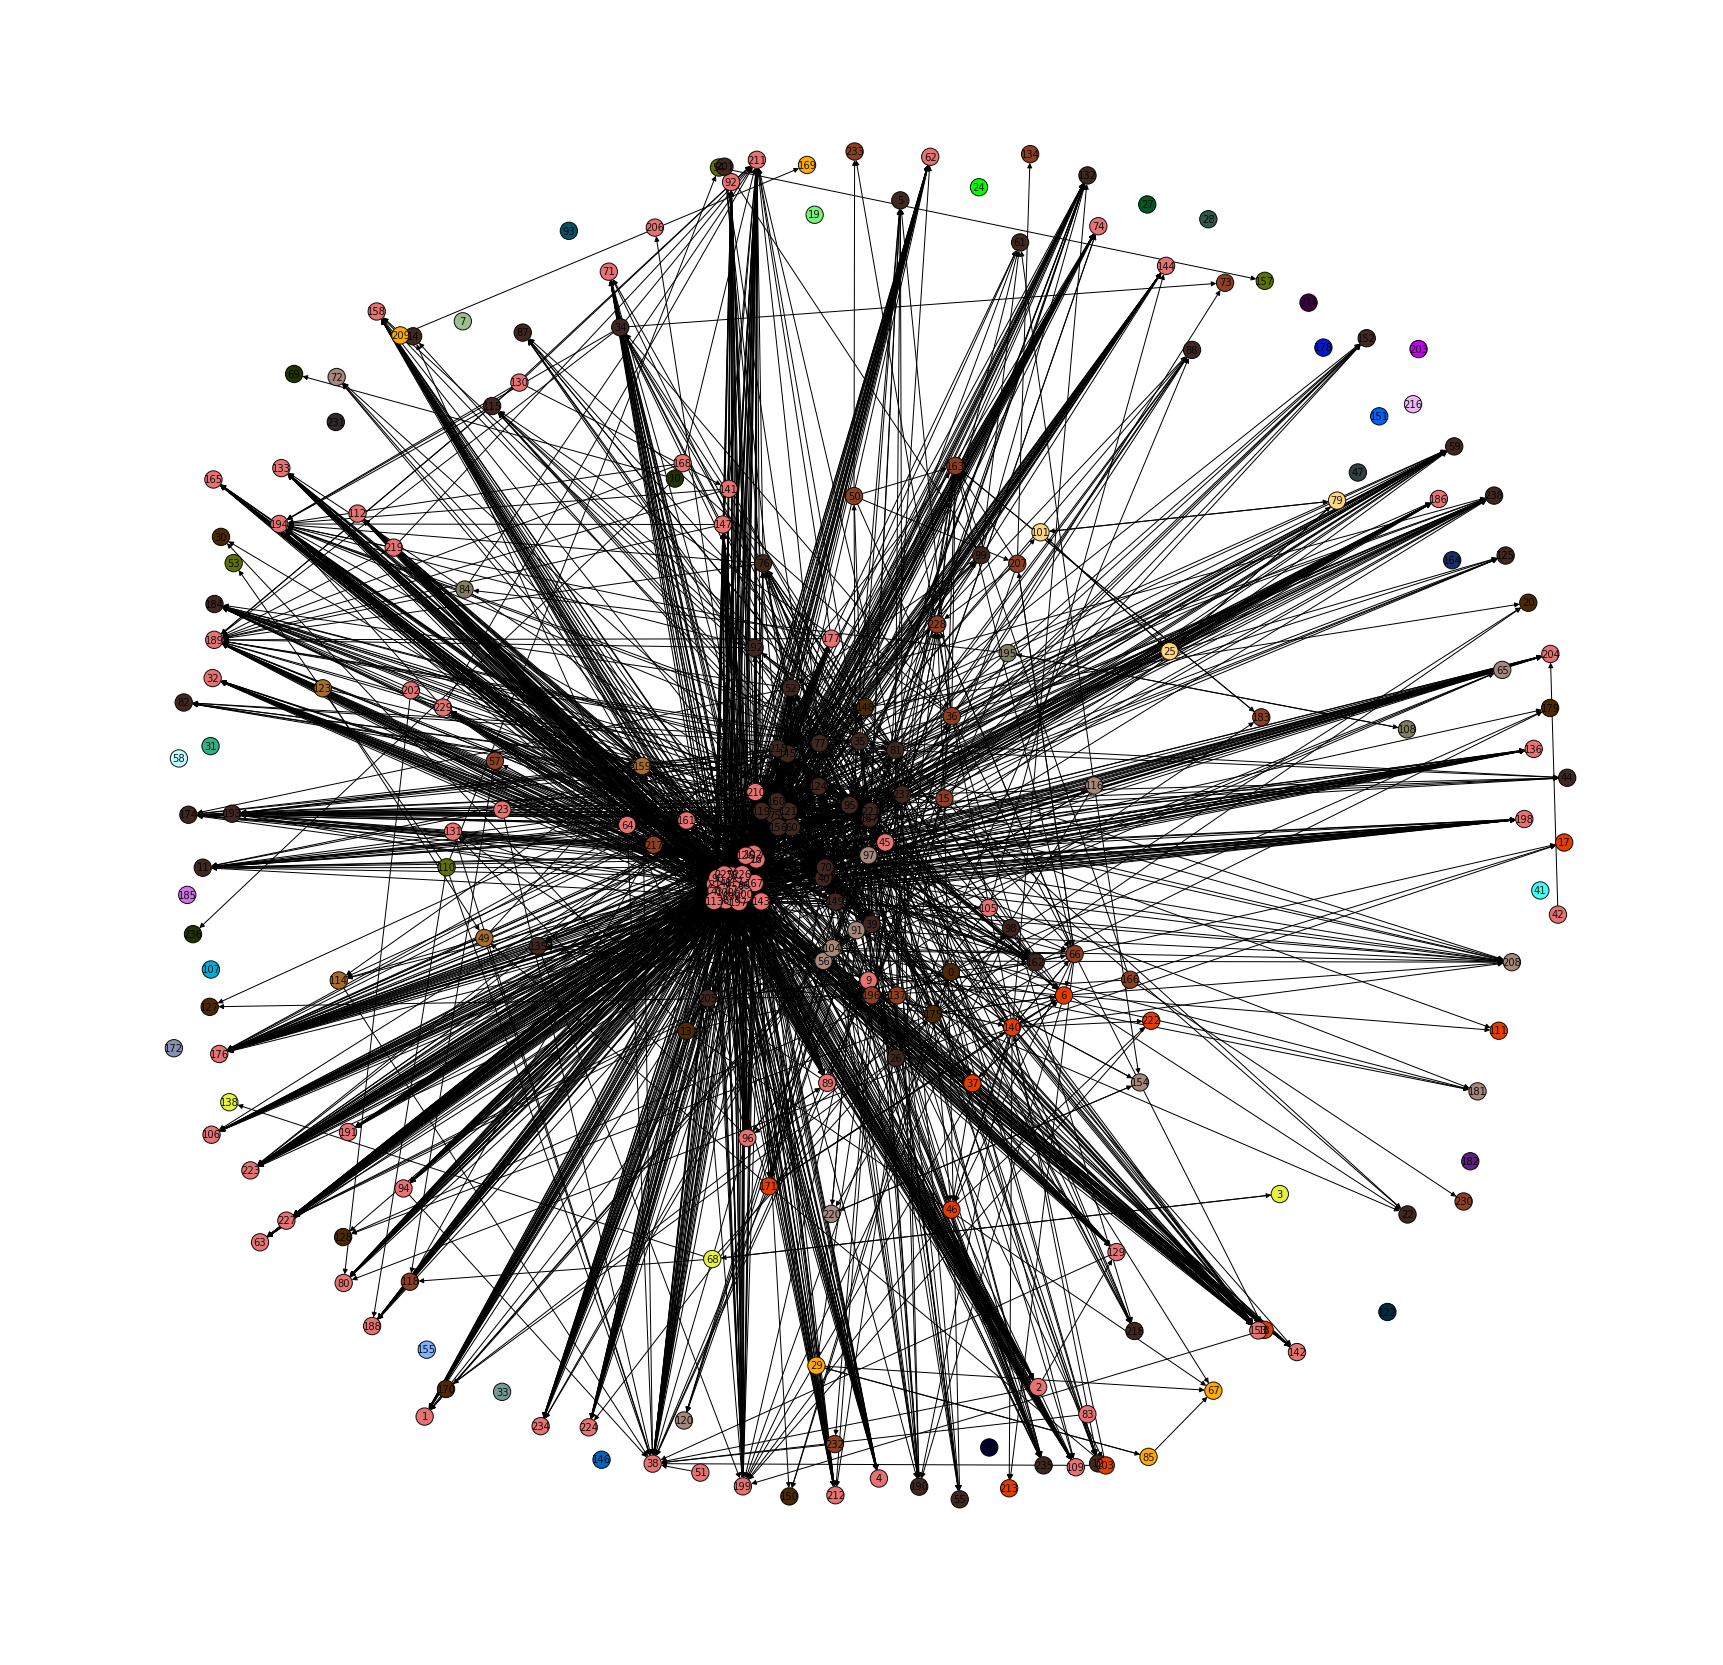

In [233]:
graph_all_int = nx.convert_node_labels_to_integers(graph_all, label_attribute='title')
findCommunities(graph_all_int)

drawNetwork(graph_all_int)

In [252]:
def list_top_communities (G, n):
    # the largest community has number 0, then 1 etc.
    # makes life easy
    for i in range(n):
        print 'Community {}:'.format(i + 1)
        nodes = filter(lambda (n, d): d['community'] == i, G.nodes(data=True))
        for n in nodes:
            data = n[1]
            name = data['Party'] if 'Party' in data else data['Name of movement']
            country = data['Country'] if 'Country' in data else data['Country of predominant operation']
            label = data['label'] if 'label' in data else ' '
            active = data['Active?'] if 'Active?' in data else '----'
            try:
                print ' - {}, {}, {} active={}'.format(name.encode('utf-8'), country, label, active)
            except UnicodeDecodeError:
                print ' - {}, {}, {} active={}'.format(data['title'], country, label, active)
list_top_communities(graph_all_int,5)

Community 1:
 - National Radical Camp-ABC (ONR-ABC), Poland, movement active=No
 - Parti Populaire Français, France, movement active=No
 - Nationaal-Socialistische Nederlandsche Arbeiderspartij, Netherlands, movement active=No
 - Clerical People's Party, Sweden, movement active=No
 - Flemish National Union, Belgium, movement active=No
 - National Fascisti, United Kingdom, movement active=No
 - La Cagoule, France, movement active=Yes
 - Nova Hrvatska Desnica, Croatia, movement active=Yes
 - Patriotic Front (Austria), Austria, movement active=No
 - Party of National Unity (SNJ), Czechoslovakia, movement active=No
 - Falange Española, Spain, movement active=Yes
 - Slovak People's Party, Slovakia, Czechoslovakia, Austria-Hungary, movement active=No
 - Black Front, Netherlands, movement active=No
 - National Corporate Party, Ireland, movement active=No
 - Phalange Française, France, movement active=No
 - Nationaal-Socialistische Beweging, Netherlands, movement active=No
 - Greek National So

In [205]:
df.to_csv('data/wikitable.csv')

In [220]:
# push infomap community up to neo4j
with driver.session() as session:
    for n in graph_all_int.nodes:
        node = graph_all_int.nodes[n]
        label = node['label'].capitalize()
        title = node['title']
        if "'" in title:
            session.run('MATCH (n:{}) WHERE n.title = "{}" SET n.info_community = {}'.format(
                label, 
                node['title'], 
                node['community']))
        else: 
            session.run("MATCH (n:{}) WHERE n.title = '{}' SET n.info_community = {}".format(
                label, 
                node['title'], 
                node['community']))

In [268]:

def graph_to_df(G):
    table = []
    for n in G.nodes:
        data = G.nodes[n]

        row = {
        'community': data['community'],
        'name': data['Party'] if 'Party' in data else data['Name of movement'],
        'country': data['Country'] if 'Country' in data else data['Country of predominant operation'],
        'label': data['label'] if 'label' in data else ' ',
        'active': data['Active?'] if 'Active?' in data else None,
        'links': data['links'],
        'title': data['title']
        }
        table.append(row)
    return pd.DataFrame(table)
    

        
        

df_all = graph_to_df(graph_all_int)
display(df_all)

active  community         country     label  \
0     None          5         Hungary     party   
1       No          0          Poland  movement   
2       No          0          France  movement   
3     None         10         Estonia     party   
4       No          0     Netherlands  movement   
5       No          1          Sweden  movement   
6     None          4           Italy     party   
7       No         13          Greece  movement   
8       No          0          Sweden  movement   
9       No          0         Belgium  movement   
10    None         12         Ukraine     party   
11      No          1  United Kingdom  movement   
12      No          1          Sweden  movement   
13    None          5         Armenia     party   
14      No          1          France  movement   
15    None          2         Germany     party   
16      No          0  United Kingdom  movement   
17    None          4           Italy     party   
18     Yes          4           Italy  movement   
19    None         14           Spain     party   
20      No          5         Hungary  movement   
21     Yes          0          France  movement   
22      No          1          Poland  movement   
23     Yes          0         Croatia  movement   
24      No         15        Portugal  movement   
25    None          7         Croatia     party   
26     Yes          1           Italy  movement   
27      No         16          Norway  movement   
28      No         17          Sweden  movement   
29    None          8         Romania     party   
..     ...        ...             ...       ...   
209   None          8         Belarus     party   
210     No          0     Switzerland  movement   
211    Yes          0          Russia  movement   
212     No          0          Sweden  movement   
213    Yes          4           Italy  movement   
214      ?         36         Denmark  movement   
215     No          1  United Kingdom  movement   
216     No         37     Switzerland  movement   
217   None          2       Lithuania     party   
218    Yes          1          Sweden  movement   
219     No          0     Netherlands  movement   
220   None          3         Georgia     party   
221    Yes          1  United Kingdom  movement   
222    Yes          4           Italy  movement   
223     No          0  United Kingdom  movement   
224     No          0         Albania  movement   
225     No          0        Bulgaria  movement   
226     No          0         Croatia  movement   
227     No          0          Poland  movement   
228   None          2           Malta     party   
229      ?          0          Russia  movement   
230    Yes          2        Slovakia  movement   
231    Yes         38          Norway  movement   
232     No          2         Austria  movement   
233   None          2          Norway     party   
234     No          0         Germany  movement   
235     No          1  United Kingdom  movement   
236   None         12         Ukraine     party   
237    Yes          1         Germany  movement   
238     No          1  United Kingdom  movement   

                                                 links  \
0    [Alain Poher, Albania, Alexander Stubb, Alfred...   
1    [1934 Montreux Fascist conference, 4th of Augu...   
2    [1934 Montreux Fascist conference, 33rd Waffen...   
3    [Christian People's Party , Communist Party of...   
4    [1934 Montreux Fascist conference, 23rd SS Vol...   
5    [Abraham Foxman, Adolf Hitler, Adrian Molin, A...   
6    [Administer Trentino, Adriana Poli Bortone, Al...   
7    [.eu, .gr, .ελ, 1000000000 , 1896 Summer Olymp...   
8    [1934 Montreux Fascist conference, 4th of Augu...   
9    [5th SS Volunteer Sturmbrigade Wallonien, 6th ...   
10   [11 December 2013 Euromaidan assault, 17 Decem...   
11   [A. K. Chesterton, Adam Walker , Alan Lake , A...   
12   [Adrian Molin, Afrikaner Weerstandsbeweging, A...   
13   [1999 Armenian parliamen

In [270]:
df_all.to_csv('data/party_movements_communities.csv',  encoding = 'utf-8')

In [ ]:
from wordcloud import WordCloud

